# Implementing Random Circuit Sampling on IBM Quantum Devices

## Using IBM Q 16 Melbourne (Manually Operated, with Plots)

Hao Li, Yue Shi, Javad Shabani

New York University

In [1]:
# Import modules to be used in the program

#from qiskit import IBMQ
import numpy as np
from math import *
from qiskit import *
from qiskit.quantum_info import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import pauli_error
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.tools.visualization import plot_histogram
from matplotlib import *
import matplotlib.pyplot as plt
import scipy as sp

qiskit.__qiskit_version__

{'qiskit-terra': '0.9.0',
 'qiskit-ignis': '0.2.0',
 'qiskit-aqua': '0.6.0',
 'qiskit': '0.12.0',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.2'}

In [2]:
# Enable IBM Quantum Experience account, e.g. IBMQ.enable_account('MY_API_TOKEN')
# Do not enable an account more than once in a session

provider = IBMQ.enable_account('25f83f7c02dd5d0fcbb4388fea110a6c56a2199a3e168dba4c179c42201a24d2b1dfaf8a323623fb7c2b60ea42a11852053ebc59d17d193a03cd73e271c022b9')

In [3]:
# Show the backends accessible

provider.backends()
#backend = provider.get_backend('ibmq_rochester')

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

## For each system, run the codes step by step to get all the results

### n-qubit system (n = 10) using ibmq_16_melbourne

In [4]:
# Choose the number of qubits in the circuits, the number of layers of random circuits, 
# and initialize the sequence number of circuit

n = 10
layers2 = 27

if n not in range(4, 16):
    print("Circuits not available for %d-qubit")

n_circ2 = 0

In [5]:
# n qubit circuits initialization (using ibmq_16_melbourne)

backend2 = provider.get_backend('ibmq_16_melbourne')

# The number of qubits registered
if n in range(4, 12):
    n_reg2 = 13
elif n in range(12, 14):
    n_reg2 = 14
else:
    n_reg2 = 15
    
# Vertices of the rectangular/trapezoid of the qubits to be used
if n in [5, 7, 9, 11, 12]:
    vert0 = 1
elif n in [4, 6, 8, 10]:
    vert0 = 2
else:
    vert0 = 0
    
if n in range(4, 12):
    vert1 = int(n / 2) + 1
    vert2 = 14 - vert1
if n in range(12, 16):
    vert1 = 6
    if n == 15:
        vert2 = 7
    else:
        vert2 = 8

vert3 = n_reg2 - 1

# List of qubits used in the circuits
q2_list = []
for i in range(vert0, vert1 + 1):
    q2_list.append(i)
for i in range(vert2, vert3 + 1):
    q2_list.append(i)

q2 = QuantumRegister(n_reg2)
c2 = ClassicalRegister(n_reg2)
circ2 = QuantumCircuit(q2, c2)

# Generate n-qubit random circuits of a number of layers
n_circ2 += 1

for k in range(0, layers2):
    # For every qubit, add a random unitary u3 gate
    for i in q2_list:
        u = quantum_info.random_unitary(2).data
        Theta = 2 * np.arccos(abs(u[0][0]))
        Phi = np.angle(u[1][0] / (u[0][0] * np.sqrt(1 - abs(u[0][0])**2)))
        Lambda =  np.angle(- u[0][1] / (u[0][0] * np.sqrt(1 - abs(u[0][0])**2)))
        Phi += 2 * np.pi * int(- np.sign(Phi) + 0.5)
        Lambda += 2 * np.pi * int(- np.sign(Lambda) + 0.5)
        circ2.u3(Theta, Phi, Lambda, q2[i])
    # Apply CNOT on several random couples of (neighbor) qubits that do not overlap
    used = []
    ranlist = []
    for l in range(n - 1):
        ranlist.append(np.random.randint(0, n))
    for l in ranlist:
        # In the rectangular/trapezoidal map of the qubits, except for the vertices, 
        # apply equal probabilities for the three connected neighbors:
        # 1/3 for vertical neighbor, and 2/3 for horizontal neighbors, with 1/3 for each side.
        # For the four vertices, only one horizontal neighbor is available, 
        # and for odd n, the single connected qubit also does not have a vertical neighbor
        i = q2_list[l]
        m = np.random.randint(0, 4)
        # 1/3 probability for vertical neighbor if available
        if m == 3:
            if (14 - i) in q2_list:
                j = 14 - i
        # For vertices, choose the only horizontal neighbor
        elif i == vert0 or i == vert2:
            j = i + 1
        elif i == vert1 or i == vert3:
            j = i - 1
        # 2/3 probabilities for horizontal neighbor, half for each side
        else:
            j = i + (- 1)**m
        # Exclude the couples that overlap with the used couples in each layer
        if (j not in used) and (i not in used):
            if i != j: # Exclude the i = j = 7 vertical case
                # Directions already included in the orders of couples, need't randomize again
                circ2.cx(q2[i], q2[j])
                print(i, j)
                used.append(j)
                used.append(i)
    print('---')      
    # Couples of qubits which are applied CNOT are printed below

5 4
2 3
8 9
11 12
---
3 2
4 5
11 10
8 9
---
10 11
6 5
9 8
3 4
---
2 3
6 5
10 11
---
3 4
5 6
10 9
12 11
---
3 4
12 2
11 10
---
12 2
5 9
11 3
---
6 5
9 10
2 3
11 12
---
11 12
9 10
6 5
3 2
---
12 2
9 10
3 4
5 6
---
5 9
10 4
2 3
12 11
---
3 11
6 5
9 10
---
2 3
8 6
10 11
---
4 5
9 10
3 11
---
5 6
2 3
9 8
12 11
---
11 3
4 5
9 10
8 6
---
10 11
8 9
12 2
---
2 12
6 5
10 9
---
5 4
9 10
11 3
---
8 9
3 2
4 5
---
3 4
12 11
8 9
---
5 9
4 3
2 12
---
8 9
3 2
11 10
6 5
---
6 5
3 2
4 10
---
2 3
4 5
9 8
---
4 10
5 6
2 3
---
3 4
8 6
9 10
---


In [6]:
# Load an OpenQasm file (without measurement) into a Quantum Circuit for statevector simulation
# (circ2 = QuantumCircuit.from_qasm_file("path/filename.qasm"))

#circ2 = QuantumCircuit.from_qasm_file("10_qubit_circuit_ibmq_16_melbourne_no_mea_L20_C1.qasm")
#circ2.draw(output = 'mpl')

JOB ID: d13d6146-5e4e-4521-a144-5d72a7fc6e46

F_XEB_statevector  =  1.0021237435172312 1.0020580377957256
F_LXEB_statevector =  0.9962151241515128 0.9951641895163448


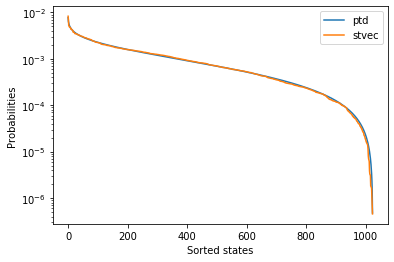

In [7]:
# Run it on statevector_simulator to work out the state amplitudes, 
# If the output stably follows the Porter-Thomas distribution, you may decide 
# whether to use fewer cycles. If not, then you have to increase the number of cycles

circuit = circ2
simulatorI = Aer.get_backend('statevector_simulator')

job2 = execute(circuit, simulatorI)
result2 = job2.result()
jobID2 = job2.job_id()
print('JOB ID: {}\n'.format(jobID2))

# Or retrieve a previous job (job2 = simulatorI.retrieve_job(jobID2))
#job2 = simulatorI.retrieve_job(cd12028b-efbe-4413-9469-004b7147de0f)
#result2 = job2.result().get_counts(circ2)

# Get the statevector from result2()
statevector2 = result2.get_statevector(circuit)

# Normalize (state2 with data cleaning order) to receive the probabilities and sort (state2_sort)
state2 = []
stvec2 = []

for i in range(0, 2**n_reg2):
    if abs(statevector2[i]) != 0:
        state2.append(np.abs(statevector2[i])**2)
        stvec2.append(statevector2[i])
        
state2 = np.array(state2)
state2_sort = - np.sort(- state2)

# Save the statevector simulation results to a file (in data cleaning order)
stvec2 = np.array(stvec2)
data2 = np.column_stack((stvec2, state2))

filename = "%d-qubit_%s_stvec_L%d_C%d_%s.csv" % (n, backend2, layers2, n_circ2, jobID2) 
np.savetxt(filename, data2, delimiter = ',')

# Ideal (discrete) Porter-Thomas distribution
N = 2**n

f = []

for i in range(0, N):
    if i == 0:
        f.append((log(N / (i + 1)) + 1) / N)
    else:
        f.append((log(N / (i + 1)) + 1 - i * log ((i + 1) / i)) / N)

# Cross-entropy benchmarking fidelities of statevector simulation (original and simplified) 
# to see how well the simulation results converge to the Porter Thomas distribution
# The fidelities should converge to 1, showing the results follow the Porter-Thomas distribution
S_inc_ptd = 0
S_exp_ptd = 0
S_ptd = 0

for i in range(0, N):
    S_inc_ptd += - log(f[i]) / N
    S_exp_ptd += - log(f[i]) * state2_sort[i]
    S_ptd += - log(f[i]) * f[i]

F_XEB_15_stvec = (S_inc_ptd - S_exp_ptd) / (S_inc_ptd - S_ptd)
F_XEB_sim_15_stvec = log(N) + np.euler_gamma - S_exp_ptd
print('F_XEB_statevector  = ', F_XEB_15_stvec, F_XEB_sim_15_stvec)

# Linear cross-entropy benchmarking fidelities of statevecror simulation (original and simplified)
SL_inc_ptd = 0
SL_exp_ptd = 0
SL_ptd = 0

for i in range(0, N):
    SL_inc_ptd += (1 - f[i]) / N
    SL_exp_ptd += (1 - f[i]) * state2_sort[i]
    SL_ptd += (1 - f[i]) * f[i]

F_LXEB_15_stvec = (SL_inc_ptd - SL_exp_ptd) / (SL_inc_ptd - SL_ptd)
F_LXEB_sim_15_stvec = 2**n * (1 - SL_exp_ptd) - 1
print('F_LXEB_statevector = ', F_LXEB_15_stvec, F_LXEB_sim_15_stvec)

# Compare the Porter-Thomas distribution with the sorted probabilities
plt.plot(f)
plt.plot(state2_sort)

plt.legend(['ptd', 'stvec'])
plt.xlabel('Sorted states')
plt.ylabel('Probabilities')
plt.yscale('log')

# The log plot of the sorted statevector amplitudes of all 2^n states (bitstrings) is printed
# If it satisfies the Porter-Thomas distribution, this circuit can be used. Go to the next steps

In [8]:
# Save the circuit (without measurement) for statevector simulation as an OpenQasm file

circ2.qasm()
file = open("%d_qubit_circuit_%s_no_mea_L%d_C%d.qasm" % (n, backend2, layers2, n_circ2), 'w')
file.write(circ2.qasm())
file.close()

In [9]:
# Apply measurement gates to the circuit, so that you can run it on IBM device

for i in q2_list:
    circ2.measure(q2[i], c2[i])

55


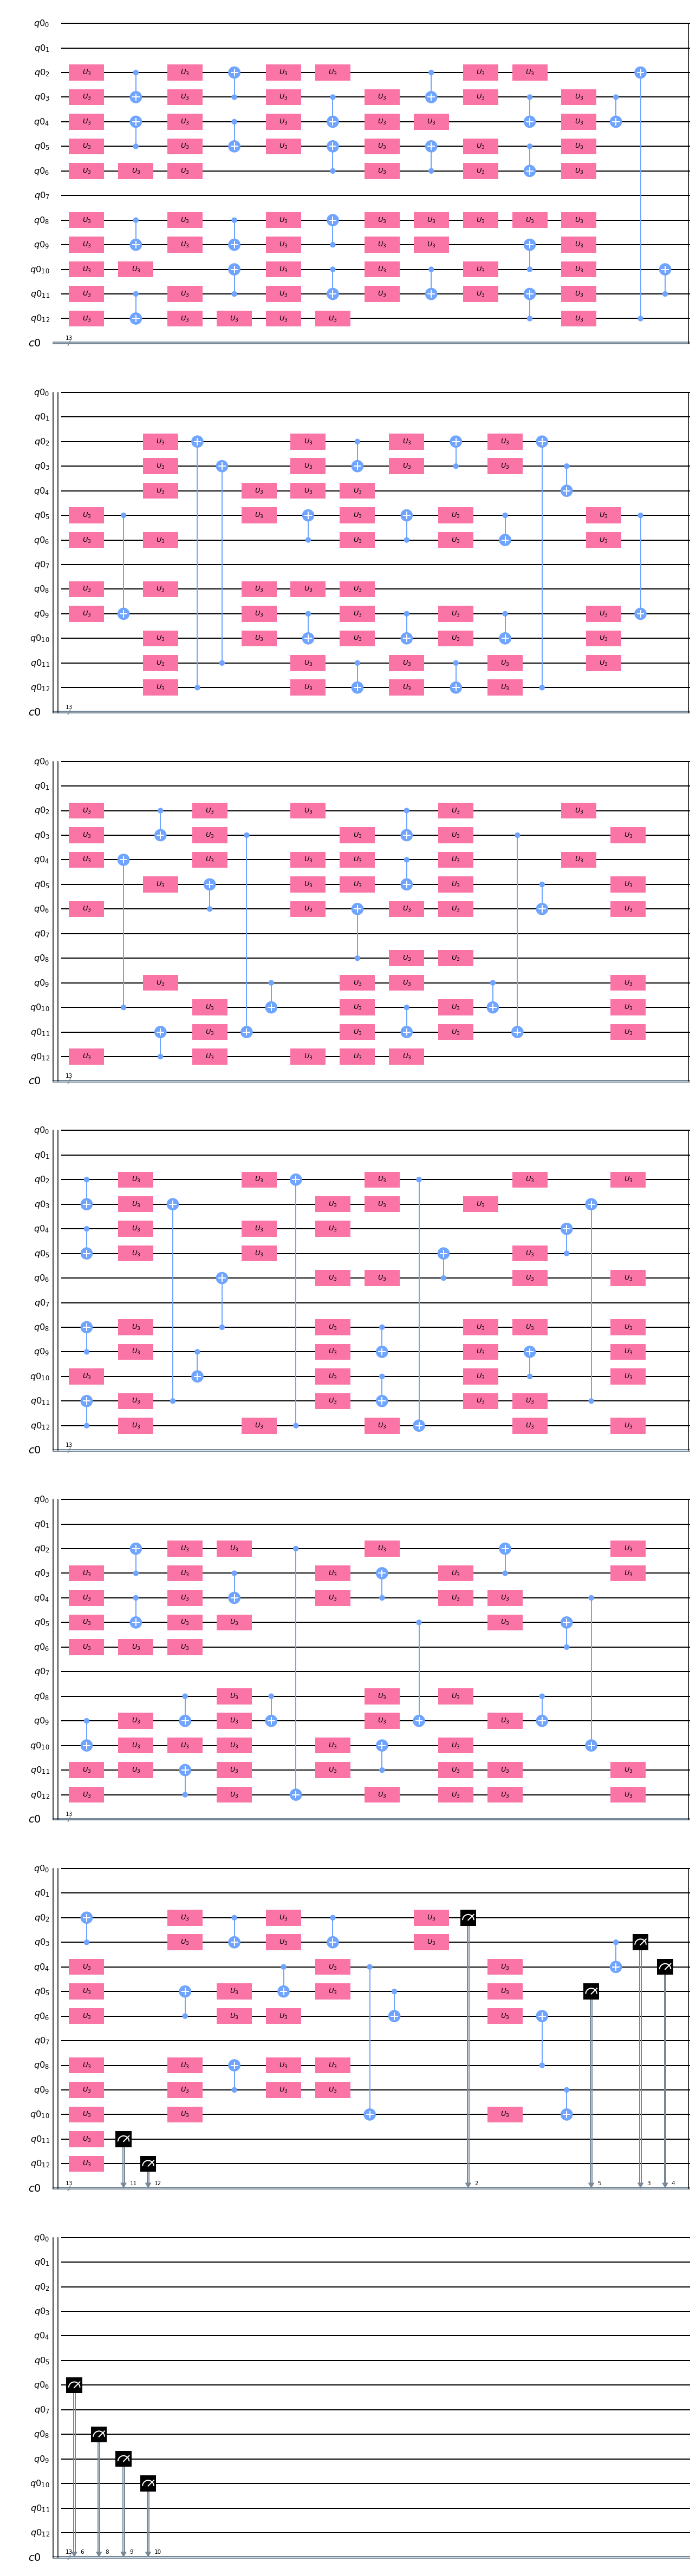

In [10]:
print(circ2.depth())
circ2.draw(output = 'mpl')

In [11]:
# Save the circuit as an OpenQasm file

circ2.qasm()
file = open("%d_qubit_circuit_%s_L%d_C%d.qasm" % (n, backend2, layers2, n_circ2), 'w')
file.write(circ2.qasm())
file.close()

In [12]:
# Load an OpenQasm file into a Quantum Circuit
# (circ2 = QuantumCircuit.from_qasm_file("path/filename.qasm"))

#circ2 = QuantumCircuit.from_qasm_file("10_qubit_circuit_ibmq_melbourne_L20_C1.qasm")
#circ2.draw(output = 'mpl')

BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec462deafc495001489e614
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec4633c80805e0013a0f175
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec4639be6f18b0013c01bba
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec463efd6ae610013e689ed
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec46438afc495001489e628
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='2.1.0', operational=True, pending_jobs=6, status_msg='active')
JOB ID: 5ec4648397dd450014f6e7f2
BackendStatus(backend_name='ibmq_1

Text(0, 0.5, 'Probabilities')

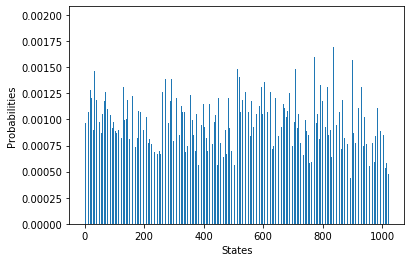

In [13]:
# Run it on actual IBM system (ibmq_16_melbourne)

runs2 = 8

counts_4_total = []
prob_4_total = []
jobID_4 = []

for run in range(1, runs2 + 1):
    shots_4 = 8192
    
    backend2 = provider.get_backend('ibmq_16_melbourne')
    print(backend2.status())
    job_4 = execute(circ2, backend2, shots = shots_4)
    result_4 = job_4.result().get_counts(circ2)
    #print(result_4)
    jobID_4.append(job_4.job_id())
    print('JOB ID: {}'.format(jobID_4[run - 1]))
    
    # Or retrieve a previous job (job_4 = backend.retrieve_job(jobID_4[i]))
    #job_4 = backend.retrieve_job(5ebf8a7d927380001bb804b5)
    #result_4 = job_4.result().get_counts(circ2)
    
# Data cleaning states(st_4), corresponding experimental counts(counts_4) & probabilities(prob_4)
    st = []
    counts = []
    prob = []
    
    for i in range(0, 2**n_reg2):
        s = '0' * n_reg2
        bin_i = np.binary_repr(i)
        
        s_i = s[0: n_reg2 - len(bin_i)] + bin_i
        st.append(s_i)
        prob.append(np.abs(statevector2[i])**2)
        try:
            counts.append(result_4[s_i])
        except:
            counts.append(0)
            
    st_4 = []
    counts_4 = []
    prob_4 = []
    for i in range(len(prob)):
        if prob[i] != 0:
            st_4.append(st[i])
            counts_4.append(counts[i])
            prob_4.append(counts[i] / shots_4) 
        #print(st_4[i], counts_4[i], prob_4[i])
    
    if run == 1:
        counts_4_total = np.array(counts_4)
    else:
        counts_4_total = np.array(counts_4_total) + np.array(counts_4)
    
    # Save the experimental results to files separately
    data_4 = np.column_stack((counts_4, prob_4))
    
    filename = "%d-qubit_%s_L%d_C%d_R%d_%s.csv" % (n, backend2, layers2, n_circ2, run, 
                                                   jobID_4[run - 1]) 
    np.savetxt(filename, data_4, delimiter = ',')
    
# Save the total counts and probabilities of all these results
prob_4_total = np.array(counts_4_total) / (runs2 * shots_4)
data_4_total = np.column_stack((counts_4_total, prob_4_total))

filename = "%d_qubit_%s_L%d_C%d_R%d_total.csv" % (n, backend2, layers2, n_circ2, runs2)
np.savetxt(filename, data_4_total, delimiter = ',')

# Histogram of the experimental results (for a single run or the total results)
#plot_histogram(result_4)
x = np.arange(len(prob_4_total))
plt.bar(x,prob_4_total,width = 0.5)
plt.xlabel('States')
plt.ylabel('Probabilities')

BackendStatus(backend_name='qasm_simulator', backend_version='0.3.0', operational=True, pending_jobs=0, status_msg='')
JOB ID: 3dff5a6a-d890-4d75-8f17-3d71efc7b353
F_XEB_qasm  =  1.0013263406685142 1.0012609632952438
F_LXEB_qasm =  0.9950808007642673 0.9940310627579265

Experimental Fidelities
F_XEB       =  -0.017094738153103084 -0.04295250681316798
F_LXEB      =  -0.015444466242989799 -0.015310455113649368
F_kXEB      =  -0.013422737043764121 -0.015363081932946443 , k =  2
F_kXEB      =  -0.01045125261706045 -0.014587471558136814 , k =  3
F_kXEB      =  -0.0077221110928374454 -0.010932137415143955 , k =  4
F_kXEB      =  -0.007329842931937173 -0.006685345175761026 , k =  5
F_kXEB      =  0.0 -0.005325983700992243 , k =  6
F_kXEB      =  -0.015638165580288205 -0.01963171312929779 , k = 1 / 2
F_kXEB      =  -0.01573419612218753 -0.023658546190859386 , k = 1 / 3
F_kXEB      =  -0.015864411740472116 -0.026680526705878727 , k = 1 / 4
F_kXEB      =  -0.015988964093468467 -0.028942662895410

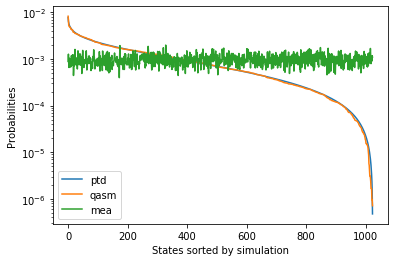

In [14]:
# Run it on Qasm simulator to simulate results on classical computer

shots_5 = 2**22

simulatorII = Aer.get_backend('qasm_simulator')
print(simulatorII.status())

math_domain_error = True
while math_domain_error == True:
    math_domain_error = False
    
    job_5 = execute(circ2, simulatorII, shots = shots_5)
    result_5 = job_5.result().get_counts(circ2)
    #print(result_5)
    jobID_5 = job_5.job_id()
    print('JOB ID: {}'.format(jobID_5))
    
    # Or retrieve a previous job (job_5 = simulatorII.retrieve_job(jobID_5))
    #job_5 = simulatorII.retrieve_job(39ff518e-73f3-4377-bd24-e7e014064b25)
    #result_5 = job_5.result().get_counts(circ2)
    
    # Data cleaning states(st_5), corresponding simulated counts(counts_5) & probabilities(prob_5)
    st = []
    counts = []
    prob = []
    
    for i in range(0, 2**n_reg2):
        s = '0' * n_reg2
        bin_i = np.binary_repr(i)
        
        s_i = s[0: n_reg2 - len(bin_i)] + bin_i
        st.append(s_i)
        prob.append(np.abs(statevector2[i])**2)
        try:
            counts.append(result_5[s_i])
        except:
            counts.append(0)
    
    st_5 = []
    counts_5 = []
    prob_5 = []
    for i in range(len(prob)):
        if prob[i] != 0:
            st_5.append(st[i])
            if counts[i] == 0:
                math_domain_error = True
            counts_5.append(counts[i])
            prob_5.append(counts[i] / shots_5)
            #print(st_5[i], counts_5[i], prob_5[i])
            
    if math_domain_error == True:
        print('Encounter zero count(s) in Qasm simulation!\n')
        
# Save the qasm simulation results to a file (in data cleaning order)
data_5 = np.column_stack((counts_5, prob_5))

filename = "%d-qubit_%s_qasm_L%d_C%d_%s.csv" % (n, backend2, layers2, n_circ2, jobID_5) 
np.savetxt(filename, data_5, delimiter = ',')

# Sort the Qasm simulation results and experimental results by Qasm simulation (descending)
prob_4_total_sort = []
prob_5_sort = []

prob_4_total_sort = np.array(prob_4_total)
prob_5_sort = - np.array(prob_5)
prob_5_sort, prob_4_total_sort = zip(*sorted(zip(prob_5_sort, prob_4_total_sort)))
prob_5_sort = - np.array(prob_5_sort)

# Ideal (discrete) Porter-Thomas distribution
N = 2**n

f = []

for i in range(0, N):
    if i == 0:
        f.append((log(N / (i + 1)) + 1) / N)
    else:
        f.append((log(N / (i + 1)) + 1 - i * log ((i + 1) / i)) / N)
        
# Cross-entropy benchmarking fidelities of Qasm simulation (original and simplified) 
# to see how well the simulation results converge to the Porter Thomas distribution
# The fidelities should converge to 1, showing the results follow the Porter-Thomas distribution
S_inc_ptd = 0
S_exp_ptd = 0
S_ptd = 0

for i in range(0, N):
    S_inc_ptd += - log(f[i]) / N
    S_exp_ptd += - log(f[i]) * prob_5_sort[i]
    S_ptd += - log(f[i]) * f[i]

F_XEB_15_qasm = (S_inc_ptd - S_exp_ptd) / (S_inc_ptd - S_ptd)
F_XEB_sim_15_qasm = log(N) + np.euler_gamma - S_exp_ptd
print('F_XEB_qasm  = ', F_XEB_15_qasm, F_XEB_sim_15_qasm)

# Linear cross-entropy benchmarking fidelities of Qasm simulation (original and simplified)
SL_inc_ptd = 0
SL_exp_ptd = 0
SL_ptd = 0

for i in range(0, N):
    SL_inc_ptd += (1 - f[i]) / N
    SL_exp_ptd += (1 - f[i]) * prob_5_sort[i]
    SL_ptd += (1 - f[i]) * f[i]

F_LXEB_15_qasm = (SL_inc_ptd - SL_exp_ptd) / (SL_inc_ptd - SL_ptd)
F_LXEB_sim_15_qasm = N * (1 - SL_exp_ptd) - 1
print('F_LXEB_qasm = ', F_LXEB_15_qasm, F_LXEB_sim_15_qasm)

print('\nExperimental Fidelities')

# Cross-entropy benchmarking fidelities of experimental results (original and simplified)
S_inc_exp = 0
S_mea_exp = 0
S_exp = 0

for i in range(0, N):
    S_inc_exp += - log(prob_5[i]) / N
    S_mea_exp += - log(prob_5[i]) * prob_4_total[i]
    S_exp += - log(prob_5[i]) * prob_5[i]

F_XEB_15 = (S_inc_exp - S_mea_exp) / (S_inc_exp - S_exp)
F_XEB_sim_15 = log(N) + np.euler_gamma - S_mea_exp
print('F_XEB       = ', F_XEB_15, F_XEB_sim_15)

# Linear cross-entropy benchmarking fidelities of experimental results (original and simplified)
SL_inc_exp = 0
SL_mea_exp = 0
SL_exp = 0

for i in range(0, N):
    SL_inc_exp += (1 - prob_5[i]) / N
    SL_mea_exp += (1 - prob_5[i]) * prob_4_total[i]
    SL_exp += (1 - prob_5[i]) * prob_5[i]

F_LXEB_15 = (SL_inc_exp - SL_mea_exp) / (SL_inc_exp - SL_exp)
F_LXEB_sim_15 = N * (1 - SL_mea_exp) - 1
print('F_LXEB      = ', F_LXEB_15, F_LXEB_sim_15)


# k-th order cross-entropy benchmarking fidelities (k = 2, 3, 4, 5, 6, and inverse) (original)
F_kXEB_15 = []
F_kXEB_sim_15 = []

for k in range(2, 7):
    Sk_inc_exp = 0
    Sk_mea_exp = 0
    Sk_exp = 0
    Pk_mea_exp = 0
    
    for i in range(0, N):
        Sk_inc_exp += (1 - prob_5[i]**k) / N
        Sk_mea_exp += (1 - prob_5[i]**k) * prob_4_total[i]
        Sk_exp += (1 - prob_5[i]**k) * prob_5[i]
        Pk_mea_exp += (prob_5[i]**k) * prob_4_total[i]
        
    F_kXEB_15.append((Sk_inc_exp - Sk_mea_exp) / (Sk_inc_exp - Sk_exp))
    F_kXEB_sim_15.append((Pk_mea_exp * N**k / gamma(k + 1) - 1) / k)
    
    print('F_kXEB      = ', F_kXEB_15[k - 2], F_kXEB_sim_15[k - 2], ', k = ', k)

F_1kXEB_15 = []
F_1kXEB_sim_15 = []

for k in range(2, 7):
    S1k_inc_exp = 0
    S1k_mea_exp = 0
    S1k_exp = 0
    P1k_mea_exp = 0
    
    for i in range(0, N):
        S1k_inc_exp += (1 - prob_5[i]**(1 / k)) / N
        S1k_mea_exp += (1 - prob_5[i]**(1 / k)) * prob_4_total[i]
        S1k_exp += (1 - prob_5[i]**(1 / k)) * prob_5[i]
        P1k_mea_exp += (prob_5[i]**(1 / k)) * prob_4_total[i]
        
    F_1kXEB_15.append((S1k_inc_exp - S1k_mea_exp) / (S1k_inc_exp - S1k_exp))
    F_1kXEB_sim_15.append((P1k_mea_exp * N**(1 / k) / gamma(1 / k + 1) - 1) * k)
    
    print('F_kXEB      = ', F_1kXEB_15[k - 2], F_1kXEB_sim_15[k - 2], ', k = 1 /', k)

# Histogram of simulation results
#plot_histogram(result_5)

# Probabilities of different states by Qasm simulation and experiment sorted by Qasm simulation
plt.plot(f)
plt.plot(prob_5_sort)
plt.plot(prob_4_total_sort)

plt.legend(['ptd', 'qasm', 'mea', 'noise'])
plt.xlabel('States sorted by simulation')
plt.ylabel('Probabilities')
plt.yscale('log')

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['id', 'cx', 'u2', 'reset', 'measure', 'u1', 'u3']
  All-qubits errors: ['cx', 'u1', 'u2', 'u3', 'id', 'measure', 'reset']
[[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]


BackendStatus(backend_name='qasm_simulator', backend_version='0.3.0', operational=True, pending_jobs=0, status_msg='')
JOB ID: 5eab7dcf-d558-47ec-bcb6-d59ade579ab6
F_XEB_qasm_noise  =  0.004638551141368782 0.004983581979439933
F_LXEB_qasm_noise =  0.004955424905341157 0.004950197292373559


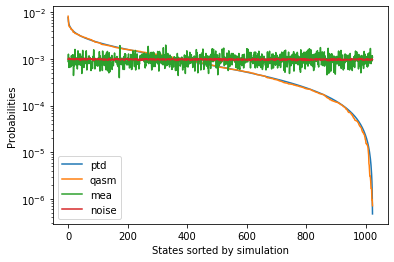

In [15]:
# Build noise model for noise simulation

basis_gates = ['u1', 'u2', 'u3', 'cx', 'id']
noise_model2 = NoiseModel(basis_gates)

p_ui = 0.0015 # Single qubit unitary gate Pauli error rate
p_id = 0.0015 # Identical gate Pauli error rate

p_cx0 = 0.01 # CNOT Pauli error rate 'XX'
p_cx1 = 0.03 # CNOT Pauli error rate 'XI'
p_cx2 = 0.03 # CNOT Pauli error rate 'IX'

p1given0 = 0.07 # Readout error to get |1> given |0>
p0given1 = 0.07 # Readout error to get |0> given |1>

T1 = 56.1 # Qubit population thermal relaxation time (in microseconds)
T2 = 56.8 # Qubit phase thermal relaxation time (in microseconds)
t1 = 0.05 # Single qubit gate time (in microseconds)
t2 = 0.1 # Two qubit gate time (in microseconds)
esp = 0.0015 # Excited state population at equilibrium (default: |0>)

p_mea = 0.01 # Measurement Pauli error rate
p_res = 0.01 # Reset Pauli error rate

error_ui = pauli_error([('X', p_ui), ('I', 1 - p_ui)])
error_id = pauli_error([('X', p_id), ('I', 1 - p_id)])
error_cx = pauli_error([('XX', p_cx0), ('XI', p_cx1), 
                        ('IX', p_cx2), ('II', 1 - p_cx0 - p_cx1 - p_cx2)])
error_ro = [[1 - p1given0, p1given0], [p0given1, 1 - p0given1]]
error_tr1 = thermal_relaxation_error(T1, T2, t1, esp)
error_tr2 = (thermal_relaxation_error(T1, T2, t2, esp).
             expand(thermal_relaxation_error(T1, T2, t2, esp)))
error_mea = pauli_error([('X', p_mea), ('I', 1- p_mea)])
error_res = pauli_error([('X', p_res), ('I', 1 - p_res)])

# All qubit error for each gate can only be applied once
#noise_model2.add_all_qubit_quantum_error(error_ui, ['u1', 'u2', 'u3'])
#noise_model2.add_all_qubit_quantum_error(error_id, 'id')
noise_model2.add_all_qubit_quantum_error(error_cx, 'cx')
noise_model2.add_all_qubit_readout_error(error_ro)
noise_model2.add_all_qubit_quantum_error(error_tr1, ['u1', 'u2', 'u3'])
noise_model2.add_all_qubit_quantum_error(error_tr1, 'id')
#noise_model2.add_all_qubit_quantum_error(error_tr2, 'cx')
noise_model2.add_all_qubit_quantum_error(error_mea, 'measure')
noise_model2.add_all_qubit_quantum_error(error_res, 'reset')
#noise_model2.add_quantum_error(error, 'reset', [1])
#noise_model2.add_nonlocal_quantum_error(error, 'reset', [0], [1])

# Get coupling map from backend
backend2 = provider.get_backend('ibmq_16_melbourne')
coupling_map = backend2.configuration().coupling_map

print(noise_model2)
print(coupling_map)
print('\n')

# Run it on Qasm simulator to simulate results with noise on classical computer
shots_6 = 2**22

simulatorII = Aer.get_backend('qasm_simulator')
print(simulatorII.status())

job_6 = execute(circ2, simulatorII, noise_model = noise_model2, 
               coupling_map = coupling_map, shots = shots_6)
result_6 = job_6.result().get_counts(circ2)
#print(result_6)
jobID_6 = job_6.job_id()
print('JOB ID: {}'.format(jobID_6))
    
# Or retrieve a previous job (job_3 = simulatorII.retrieve_job(jobID_6))
#job_6 = simulatorII.retrieve_job(feba6fd8-c758-4648-ad82-45f35b324c85)
#result_6 = job_6.result().get_counts(circ2)

# Data cleaning states(st_6), corresponding simulated counts(counts_6) & probabilities(prob_6)
st = []
counts = []
prob = []

for i in range(0, 2**n_reg2):
    s = '0' * n_reg2
    bin_i = np.binary_repr(i)
    
    s_i = s[0: n_reg2 - len(bin_i)] + bin_i
    st.append(s_i)
    prob.append(np.abs(statevector2[i])**2)
    try:
        counts.append(result_6[s_i])
    except:
        counts.append(0) 

st_6 = []
counts_6 = []
prob_6 = []
for i in range(len(prob)):
    if prob[i] != 0:
        st_6.append(st[i])
        counts_6.append(counts[i])
        prob_6.append(counts[i] / shots_6)
        #print(st_6[i], counts_6[i], prob_6[i])
        
# Save the Qasm noise simulation results to a file (in data cleaning order)
data_6 = np.column_stack((counts_6, prob_6))

filename = "%d-qubit_%s_qasm_noise_L%d_C%d_%s.csv" % (n, backend2, layers2, n_circ2, jobID_6)
np.savetxt(filename, data_6, delimiter = ',')

# Sort the Qasm simulation and noise simulation results by Qasm simulation results (descending)
prob_6_sort = []
prob_5_sort = []

prob_6_sort = np.array(prob_6)
prob_5_sort = - np.array(prob_5)
prob_5_sort, prob_6_sort = zip(*sorted(zip(prob_5_sort, prob_6_sort)))
prob_5_sort = - np.array(prob_5_sort)

# Ideal (discrete) Porter-Thomas distribution
N = 2**n

f = []

for i in range(0, N):
    if i == 0:
        f.append((log(N / (i + 1)) + 1) / N)
    else:
        f.append((log(N / (i + 1)) + 1 - i * log ((i + 1) / i)) / N)
        
# Cross-entropy benchmarking fidelities of Qasm noise simulation (original and simplified) 
S_inc_ptd = 0
S_exp_ptd = 0
S_ptd = 0

for i in range(0, N):
    S_inc_ptd += - log(f[i]) / N
    S_exp_ptd += - log(f[i]) * prob_6_sort[i]
    S_ptd += - log(f[i]) * f[i]

F_XEB_15_qasm_noise = (S_inc_ptd - S_exp_ptd) / (S_inc_ptd - S_ptd)
F_XEB_sim_15_qasm_noise = log(N) + np.euler_gamma - S_exp_ptd
print('F_XEB_qasm_noise  = ', F_XEB_15_qasm_noise, F_XEB_sim_15_qasm_noise)

# Linear cross-entropy benchmarking fidelities of Qasm noise simulation (original and simplified)
SL_inc_exp = 0
SL_mea_exp = 0
SL_exp = 0

for i in range(0, N):
    SL_inc_exp += (1 - f[i]) / N
    SL_mea_exp += (1 - f[i]) * prob_6_sort[i]
    SL_exp += (1 - f[i]) * f[i]

F_LXEB_15_qasm_noise = (SL_inc_exp - SL_mea_exp) / (SL_inc_exp - SL_exp)
F_LXEB_sim_15_qasm_noise = N * (1 - SL_mea_exp) - 1
print('F_LXEB_qasm_noise = ', F_LXEB_15_qasm_noise, F_LXEB_sim_15_qasm_noise)

# Save all the calculated fidelities ((noise) simulation, and experiment)
filename = "%d-qubit_%s_fidelities_L%d_C%d.csv" % (n, backend2, layers2, n_circ2)
file2 = open(filename, "w")
file2.write("%s\n" % backend2.status())
file2.write("%s\n" % simulatorII.status())
file2.write("Number of qubits in the circuit, %d\n" % n)
file2.write("Number of layers of circuits, %d\n" % layers2)
file2.write("Circuit sequence number, %d\n" % n_circ2)
file2.write("Depth of the circuit, %d\n" % circ2.depth())
file2.write("Number of runs (8192 times each), %d\n\n" % runs2)

file2.write("Job ID of simulations and experiments\n")
file2.write("Statevector simulation, %s\n" % jobID2)
file2.write("Qasm simulation, %s\n" % jobID_5)
file2.write("Qasm noise simulation, %s\n" % jobID_6)

for run in range(1, runs2 + 1):
    file2.write("%s experiment %d, %s\n" % (backend2, run, jobID_4[run - 1]))
file2.write("\n")

file2.write("Fidelities (original and simplified) of simulations and experiment,")
file2.write("Origial idelities, Simplified fidelities, k for k'th order fidelities\n")
file2.write("F_XEB(_sim)_statevector, %.17f, %.17f\n" % (F_XEB_15_stvec, F_XEB_sim_15_stvec))
file2.write("F_LXEB(_sim)_statevector, %.17f, %.17f\n" % (F_LXEB_15_stvec, F_LXEB_sim_15_stvec))
file2.write("F_XEB(_sim)_qasm, %.17f, %.17f\n" % (F_XEB_15_qasm, F_XEB_sim_15_qasm))
file2.write("F_LXEB(_sim)_qasm, %.17f, %.17f\n" % (F_LXEB_15_qasm, F_LXEB_sim_15_qasm))
file2.write("F_XEB(_sim)_qasm_noise, %.17f, %.17f\n" % 
            (F_XEB_15_qasm_noise, F_XEB_sim_15_qasm_noise))
file2.write("F_LXEB(_sim)_qasm_noise, %.17f, %.17f\n" % 
            (F_LXEB_15_qasm_noise, F_LXEB_sim_15_qasm_noise))
file2.write("F_XEB(_sim), %.17f, %.17f\n" % (F_XEB_15, F_XEB_sim_15))
file2.write("F_LXEB(_sim), %.17f, %.17f, 1\n" % (F_LXEB_15, F_LXEB_sim_15))

for k in range (2, 7):
    file2.write("F_kXEB(_sim), %.17f, %.17f, %d\n" % 
                (F_kXEB_15[k - 2], F_kXEB_sim_15[k - 2], k))

for k in range (2, 7):
    file2.write("F_kXEB(_sim), %.17f, %.17f, %.17f, 1/%d\n" % 
                (F_1kXEB_15[k - 2], F_1kXEB_sim_15[k - 2], (1 / k), k))

file2.close()

# Histogram of simulation results
#plot_histogram(result_3)

# Probabilities of states by Qasm (noise) simulations and experiment sorted by Qasm simulation
plt.plot(f) # blue, theoretical
plt.plot(prob_5_sort) # orange, Qasm
plt.plot(prob_4_total_sort) # green, experimental
plt.plot(prob_6_sort) # red, noise Qasm

plt.legend(['ptd', 'qasm', 'mea', 'noise'])
plt.xlabel('States sorted by simulation')
plt.ylabel('Probabilities')
plt.yscale('log')

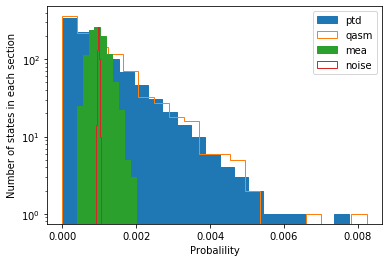

In [16]:
# Histogram of the probabilities

plt.hist(f, bins = 20, histtype = 'step', stacked = True, fill = True) # blue, theoretical
plt.hist(prob_5, bins = 20, histtype = 'step', stacked = True, fill = False) # orange, Qasm
plt.hist(prob_4_total, bins = 10, histtype = 'step', stacked = True, 
         fill = True) # green, ibmq_16_melbourne
plt.hist(prob_6, bins = 10, histtype = 'step', stacked = True, fill = False) # red, noise Qasm

plt.legend(['ptd', 'qasm', 'mea', 'noise'])
plt.xlabel('Probalility')
plt.ylabel('Number of states in each section')
plt.yscale('log')